In [65]:
from gurobipy import *
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

# Testing

In [116]:
output_file = 'variable_values'


In [117]:
results = pd.read_table(f'../output/{output_file}.txt')
n = results[results["results"].str.contains("n")]
u = results[results["results"].str.contains("u")]
c = results[results["results"].str.contains("c")]
varn = n['results'].str.split('=').apply(lambda x: x[0])
valn = n['results'].str.split('=').apply(lambda x: x[1])
t = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
k = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
amount = valn
specificn = pd.DataFrame(np.array([t,i,k,amount]).T).reset_index(drop=True)
specificn.columns = ['t','i', 'k', 'amount']
specificn['name'] = 'n'

varu = u['results'].str.split('=').apply(lambda x: x[0])
valu = u['results'].str.split('=').apply(lambda x: x[1])
t = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
j = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
k = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valu
specificu = pd.DataFrame(np.array([t,i,j,k,amount]).T).reset_index(drop=True)
specificu.columns = ['t','i', 'j', 'k', 'amount']
specificu['name'] = 'u'

varc = c['results'].str.split('=').apply(lambda x: x[0])
valc = c['results'].str.split('=').apply(lambda x: x[1])
t = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
x = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
y = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valc
specificc = pd.DataFrame(np.array([t,i,x,y,amount]).T).reset_index(drop=True)
specificc.columns = ['t','i', 'x', 'y', 'amount']
specificc['name'] = 'c'
specificn['amount'] = specificn['amount'].astype(float)
specificu['amount'] = specificu['amount'].astype(float)
specificc['amount'] = specificc['amount'].astype(float)


In [118]:
specificu01 = specificu[specificu['i'] == 0]
specificu10 = specificu[specificu['i'] == 1]

In [119]:
specificu01 = specificu01.groupby('t').sum().reset_index()
specificu10 = specificu10.groupby('t').sum().reset_index()


In [120]:
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [121]:
specificc

,t,i,x,y,amount,name
0,0,0,1,2,1.0,c
1,0,0,2,3,1.0,c
2,0,1,2,3,2.0,c
3,1,0,2,3,1.0,c
4,3,1,2,3,1.0,c
...,...,...,...,...,...,...
966,571,1,0,3,1.0,c
967,573,1,0,4,3.0,c
968,574,1,0,3,2.0,c
969,575,0,2,4,1.0,c


In [122]:
specificu

,t,i,j,k,amount,name
0,0,0,1,1,2.0,u
1,0,1,0,4,2.0,u
2,1,0,1,3,1.0,u
3,1,1,0,3,2.0,u
4,2,0,1,3,1.0,u
...,...,...,...,...,...,...
1556,573,0,1,1,2.0,u
1557,573,1,0,3,1.0,u
1558,574,0,1,2,2.0,u
1559,574,1,0,3,1.0,u


In [123]:
all_c = np.zeros(shape=(1,577), dtype=int)
for i in range(specificc.shape[0]):
    val = int(specificc['amount'][i])
    soc0 = int(specificc['x'][i])
    soc1 = int(specificc['y'][i])
    t = int(specificc['t'][i])
    time_charge = int(gamma[soc0: soc1].sum())
    occupied = np.zeros(shape=(val,577))
    for j in range(val):
        occupied[j][t:t+time_charge] = 1

    all_c = np.concatenate([all_c, occupied], axis=0)
all_c = all_c[1:,:]

all_u = np.zeros(shape=(1,577), dtype=int)
for i in range(specificu.shape[0]):
    val = int(specificu['amount'][i])
    t = int(specificu['t'][i])
    flight_time = 2
    flight = np.zeros(shape=(val,577))
    for j in range(val):
        flight[j][t:t+flight_time] = 1

    all_u = np.concatenate([all_u, flight], axis=0)
all_u = all_u[1:,:]

In [124]:

all_n = np.zeros(shape=(1,577), dtype=int)
for i in range(specificn.shape[0]):
    val = int(specificn['amount'][i])
    t = int(specificn['t'][i])
    idle = np.zeros(shape=(val,577))
    for j in range(val):
        idle[j][t] = 1
    all_n = np.concatenate([all_n, idle], axis=0)
all_n = all_n[1:,:]

<AxesSubplot:>

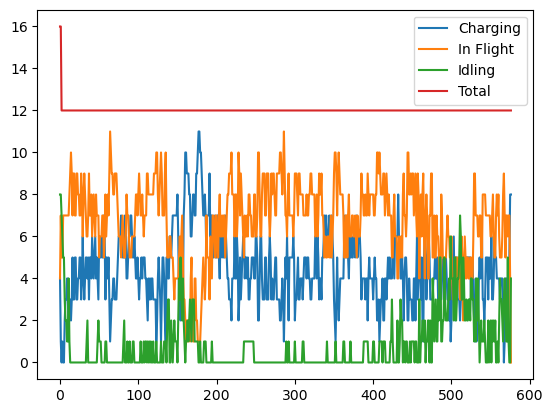

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.lineplot(all_c.sum(axis=0), label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0), label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0), label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0) + all_u.sum(axis=0)+all_n.sum(axis=0)), label='Total', ax=ax)

<AxesSubplot:>

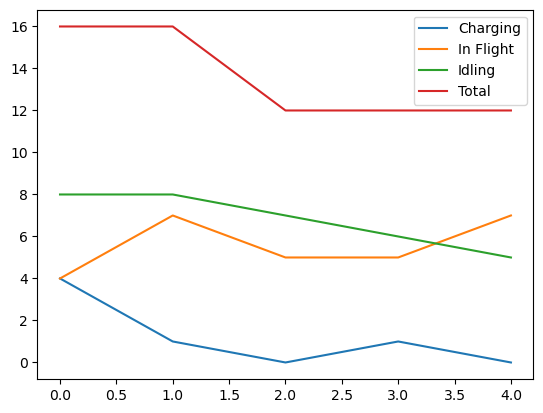

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.lineplot(all_c.sum(axis=0)[:5], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[:5], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[:5], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[:5] + all_u.sum(axis=0)[:5]+all_n.sum(axis=0)[:5]), label='Total', ax=ax)

In [86]:
gamma[soc0: soc1].sum()

2.0

In [29]:
gamma

array([ 1.,  1.,  1.,  2.,  2.,  2.,  4., 15.])

In [7]:
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [34]:
import pandas as pd

In [36]:
schedule = pd.read_csv('../input/schedule.csv')
schedule['schedule'] = schedule['schedule'] // 5 * 5
schedule[schedule['od'] == 'LAX_DTLA']

u_lax_dtla = []
u_dtla_lax = []
for i in range(0,1440,5):
    id = schedule[(schedule['od'] == 'LAX_DTLA') & (schedule['schedule'] == i)]
    u_lax_dtla.append(id.shape[0])
    id = schedule[(schedule['od'] == 'DTLA_LAX') & (schedule['schedule'] == i)]
    u_dtla_lax.append(id.shape[0])
u_lax_dtla = np.array(u_lax_dtla)
u_dtla_lax = np.array(u_dtla_lax)

In [ ]:
# Data from specificu
specificu_t01 = list(specificu01['t'])
specificu_amount01 = list(specificu01['amount'])
specificu_t10 = list(specificu10['t'])
specificu_amount10 = list(specificu10['amount'])


In [55]:
lax_dtla_repositioning = pd.DataFrame({'t':specificu_t01, 'lax_dtla':specificu_amount01})
lax_dtla_repositioning.to_csv('lax_dtla_repositioning.csv', index=False)
dtla_lax_repositioning = pd.DataFrame({'t':specificu_t10, 'lax_dtla':specificu_amount10})
dtla_lax_repositioning.to_csv('dtla_lax_repositioning.csv', index=False)

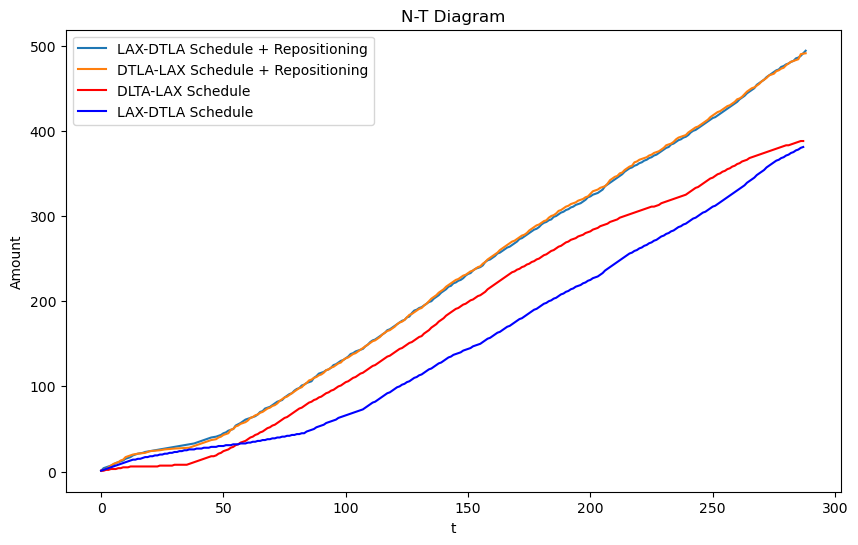

In [59]:

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(specificu_t01, np.cumsum(specificu_amount01), label='LAX-DTLA Schedule + Repositioning')
plt.plot(specificu_t10, np.cumsum(specificu_amount10), label='DTLA-LAX Schedule + Repositioning')
plt.plot(np.cumsum(u_dtla_lax),color='red', label='DLTA-LAX Schedule')
plt.plot(np.cumsum(u_lax_dtla),color='blue', label='LAX-DTLA Schedule')
plt.xlabel('t')
plt.ylabel('Amount')
plt.title('N-T Diagram')
plt.legend()
plt.show()


In [25]:


# Data from specificn
specificn_t = list(specificn['t'])
specificn_amount = list(specificn['amount'])

# Data from specificu
specificu_t = list(specificu['t'])
specificu_amount = list(specificu['amount'])

# Data from specificc
specificc_t = list(specificc['t'])
specificc_amount = list(specificc['amount'])

In [26]:
specificn

,t,i,k,amount,name
0,0,0,8,5.0,n
1,0,1,8,7.0,n
2,1,0,8,2.0,n
3,1,1,8,6.0,n
4,2,0,8,1.0,n
...,...,...,...,...,...
73,269,1,1,1.0,n
74,278,1,3,1.0,n
75,282,1,0,2.0,n
76,284,0,2,1.0,n


In [27]:
specificu

,t,i,j,k,amount,name
0,0,0,1,8,1.0,u
1,0,1,0,8,1.0,u
2,1,0,1,8,3.0,u
3,1,1,0,8,1.0,u
4,2,0,1,8,1.0,u
...,...,...,...,...,...,...
792,286,1,0,2,4.0,u
793,286,1,0,3,2.0,u
794,288,0,1,1,4.0,u
795,288,0,1,2,2.0,u


In [28]:
specificc

,t,i,x,y,amount,name
0,3,1,7,8,1.0,c
1,5,0,6,8,1.0,c
2,9,0,4,6,1.0,c
3,11,0,3,8,1.0,c
4,11,1,6,7,1.0,c
...,...,...,...,...,...,...
522,285,0,2,3,1.0,c
523,286,1,0,3,2.0,c
524,287,0,3,4,1.0,c
525,287,1,0,2,1.0,c
